# Простой пример бинарной классификации

In [2]:
#подключаем библиотеки
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import CenterCrop
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

#выводим версию библиотеки tensorflow и количество доступных видеокарт
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2022-11-21 18:51:43.175626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 18:51:43.313612: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 18:51:43.761024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/a.samarin/workspace/anaconda3/envs/top-env/lib/:/home/a.samarin/workspace/anaconda3/envs/top-env/lib/
2022-11-21 18:51:43.761093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not l

2.10.0
Num GPUs Available:  1


2022-11-21 18:51:45.098446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 18:51:45.105073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 18:51:45.106479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
#простейшая структура датасета для задачи классификации
#  main_directory/
#  ...class_a/
#  ......a_image_1.jpg
#  ......a_image_2.jpg
#  ...class_b/
#  ......b_image_1.jpg
#  ......b_image_2.jpg

In [ ]:
# загрузим датасет
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [ ]:
#!unzip -q kagglecatsanddogs_5340.zip
#!ls
#!ls PetImages

In [ ]:
# уберем поврежденные файлы
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

In [3]:
#создаем модель

num_classes = 2

inputs = keras.Input(shape=(None, None, 3))
x = CenterCrop(height=150, width=150)(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

#data = np.random.randint(0, 256, size=(64, 200, 200, 3)).astype("float32")

#processed_data = model(data)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 center_crop_1 (CenterCrop)  (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                       

In [11]:
#создаем окружение для работы с датасетами
image_size = 180
train_dir, validation_dir =  "PetImages","PetImages"
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
 
#устанавливаем размер пакетов 
train_batchsize = 100
val_batchsize = 10
 
#создаем генератор данных для обучения
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
#создаем генератор данных для валидации
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

#устанавливаем параметры для оптимизации
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#настраиваем сохранение весов
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='saved_weights/model_{epoch}.h5',
        save_freq='epoch')
]  

#запускаем процесс тренировки модели
history = model.fit(
      train_generator,
      steps_per_epoch=
         train_generator.samples/train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator, 
      validation_steps=
         validation_generator.samples/validation_generator.batch_size,
      verbose=1,
      callbacks=callbacks)

Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Epoch 1/20


2022-11-21 03:37:59.676163: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-21 03:38:00.178981: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 9.2.148, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-21 03:38:00.180601: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2022-11-21 03:38:00.180616: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-21 03:38:00.180677: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be o

1/6 [====>.........................] - ETA: 26s - loss: 0.8992 - acc: 0.5400

2022-11-21 03:38:03.715055: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6/6 [==============================] - 9s 703ms/step - loss: 2.2469 - acc: 0.5100 - val_loss: 0.6279 - val_acc: 0.6900
Epoch 2/20
6/6 [==============================] - 3s 601ms/step - loss: 0.4796 - acc: 0.7667 - val_loss: 0.2718 - val_acc: 0.8900
Epoch 3/20
6/6 [==============================] - 3s 598ms/step - loss: 0.3370 - acc: 0.8600 - val_loss: 0.2663 - val_acc: 0.8733
Epoch 4/20
6/6 [==============================] - 3s 600ms/step - loss: 0.4570 - acc: 0.7967 - val_loss: 0.8358 - val_acc: 0.6533
Epoch 5/20
6/6 [==============================] - 3s 600ms/step - loss: 0.3547 - acc: 0.8367 - val_loss: 0.1738 - val_acc: 0.9317
Epoch 6/20
6/6 [==============================] - 3s 600ms/step - loss: 0.3856 - acc: 0.8267 - val_loss: 0.1798 - val_acc: 0.9200
Epoch 7/20
6/6 [==============================] - 3s 595ms/step - loss: 0.1762 - acc: 0.9317 - val_loss: 0.1236 - val_acc: 0.9583
Epoch 8/20
6/6 [==============================] - 3s 599ms/step - loss: 0.1755 - acc: 0.9217 - val_lo

### не особо получилось... Это нормально. Воспользуемся стандартной тактикой - возьмем модель помощнее с претрейном imagenet

In [3]:
#импортируем встроенную в keras, классическую нейросетевую архитектуру
from tensorflow.keras.applications import vgg16
image_size = 180 

#загружаем архитектуру vgg16 c imagenet весами
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
print(vgg_conv.summary())
#keras.utils.plot_model(vgg_conv, show_shapes=True)


2022-11-21 18:52:09.583262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 18:52:09.591428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 18:52:09.592908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 18:52:09.594144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [4]:
#создаем модель с основанием из vgg16 и надстройкой под нашу задачу
model = keras.Sequential()
model.add(vgg_conv)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))
print(model.summary())
#keras.utils.plot_model(model, show_shapes=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 1024)              13108224  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 27,824,962
Trainable params: 27,824,962
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
#запрещаем слоям из основания обучаться
for layer in vgg_conv.layers[:]:
    layer.trainable = False

#проверяем обучаемость у слоев всей модели
for layer in vgg_conv.layers:
    print(layer, layer.trainable)



<keras.engine.input_layer.InputLayer object at 0x7f9be0a47fa0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9be0a68e80> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9be0a11310> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f9be0a11d60> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9be0a11670> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bd8594040> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f9bd831dd00> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bd831d910> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bd8594550> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bd832a7c0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f9bd832aee0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bd832abe0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bd833d280> False
<keras.layers.convolut

In [6]:
#создаем окружение для работы с датасетами
image_size = 180
train_dir, validation_dir =  "PetImages","PetImages"
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
 
#устанавливаем размер пакетов 
train_batchsize = 100
val_batchsize = 10
 
#создаем генератор данных для обучения
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
#создаем генератор данных для валидации
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

#задаем способ обучения
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#настраиваем сохранение весов
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='saved_weights/model_{epoch}.h5',
        save_freq='epoch')
]  

#запускаем тренировку модели
history = model.fit(
      train_generator,
      steps_per_epoch=
         train_generator.samples/train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator, 
      validation_steps=
         validation_generator.samples/validation_generator.batch_size,
      verbose=1,
      callbacks=callbacks)




Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


/home/a.samarin/workspace/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20


2022-11-21 18:53:18.688067: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-21 18:53:19.182736: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 9.2.148, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-21 18:53:19.183871: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2022-11-21 18:53:19.183885: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-21 18:53:19.183933: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be o

1/6 [====>.........................] - ETA: 26s - loss: 0.7546 - acc: 0.6000

2022-11-21 18:53:22.774267: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6/6 [==============================] - 9s 712ms/step - loss: 2.0149 - acc: 0.5517 - val_loss: 0.6461 - val_acc: 0.6417
Epoch 2/20
6/6 [==============================] - 3s 611ms/step - loss: 0.5795 - acc: 0.7250 - val_loss: 0.2778 - val_acc: 0.8850
Epoch 3/20
6/6 [==============================] - 3s 589ms/step - loss: 0.4163 - acc: 0.8067 - val_loss: 0.3443 - val_acc: 0.8367
Epoch 4/20
6/6 [==============================] - 3s 608ms/step - loss: 0.4008 - acc: 0.8183 - val_loss: 0.5513 - val_acc: 0.7133
Epoch 5/20
6/6 [==============================] - 3s 588ms/step - loss: 0.3211 - acc: 0.8500 - val_loss: 0.1661 - val_acc: 0.9400
Epoch 6/20
6/6 [==============================] - 3s 600ms/step - loss: 0.2200 - acc: 0.9133 - val_loss: 0.2673 - val_acc: 0.8717
Epoch 7/20
6/6 [==============================] - 3s 583ms/step - loss: 0.4516 - acc: 0.7783 - val_loss: 0.2139 - val_acc: 0.9067
Epoch 8/20
6/6 [==============================] - 3s 609ms/step - loss: 0.1437 - acc: 0.9467 - val_lo

### Ура! Обучилось! Теперь можем использовать обученный классификатор!

In [28]:
#как выглядит запуск обученной модели для классификации произвольного изображения
img = keras.preprocessing.image.load_img("PetImages/Cat/10008.jpg", target_size=(image_size, image_size))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #создаем пакет из одной картинки
predictions = model.predict(img_array)
#print(predictions)
score = float(predictions[0][0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 27ms/step
This image is 100.00% cat and 0.00% dog.


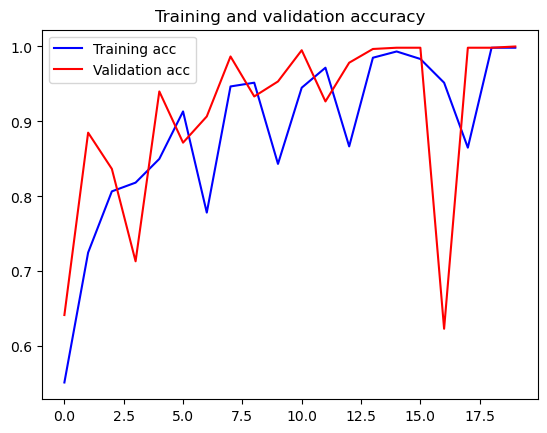

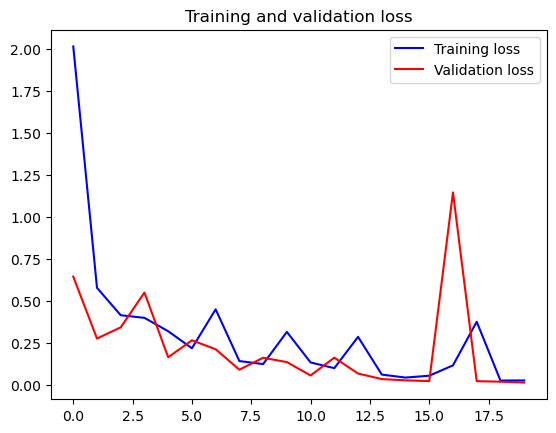

In [7]:
#посмотрим на то, как менялись значения функции потерь и метрик качества в процессе обучения

def visualize_results(history):

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()
 
 
visualize_results(history)

In [8]:
#вот таким образом можно ознакомиться с примерами, на которых модель ошибается
def obtain_errors(val_generator, predictions):

    fnames = validation_generator.filenames
 
    ground_truth = validation_generator.classes
 
    label2index = validation_generator.class_indices
 
    idx2label = list(label2index.keys())
    print("The list of classes: ", idx2label)
 
    predicted_classes = np.argmax(predictions, axis=1)
 
    errors = np.where(predicted_classes != ground_truth)[0]
    print("Number of errors = {}/{}".format(len(errors),validation_generator.samples))
     
    return idx2label, errors, fnames
 
    
def show_errors(idx2label, errors, predictions, fnames):
    for i in range(len(errors)):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]
 
        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])
 
        original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()


predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
 
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)
 
show_errors(idx2label, errors, predictions, fnames)

60/60 [==============================] - 2s 23ms/step
The list of classes:  ['Cat', 'Dog']
Number of errors = 0/600


# Подробнее про возможности keras/tf

In [9]:
#основным объектом является тензор
x = tf.constant([[5, 2], [1, 3]])
print(x)


tf.Tensor(
[[5 2]
 [1 3]], shape=(2, 2), dtype=int32)


In [10]:
#тензор можно сконвертировать в numpy массив
x.numpy()

array([[5, 2],
       [1, 3]], dtype=int32)

In [11]:
#основные характеристики тензора - это тип и значение
print("dtype:", x.dtype)
print("shape:", x.shape)

dtype: <dtype: 'int32'>
shape: (2, 2)


In [12]:
#задавать и инициализировать тензоры можно так:
print(tf.ones(shape=(2, 1)))
print(tf.zeros(shape=(2, 1)))

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


In [14]:
#тензоры можно инициализировать сгенерированным изначениями из заданных распределений
x = tf.random.normal(shape=(2, 2), mean=0.0, stddev=1.0)
print(x)

x = tf.random.uniform(shape=(2, 2), minval=0, maxval=10, dtype="int32")
print(x)

tf.Tensor(
[[-1.0706898   0.73063344]
 [-1.854926   -0.20702787]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[4 5]
 [5 6]], shape=(2, 2), dtype=int32)


In [15]:
#значение тензора можно присваивать переменной - это изменяемый объект из инфраструктуры tf
initial_value = tf.random.normal(shape=(2, 2))
a = tf.Variable(initial_value)
print(a)

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-1.9459037 , -0.6754717 ],
       [-0.03191435, -0.9179135 ]], dtype=float32)>


In [16]:
#переменным можно присваивать новые значения
new_value = tf.random.normal(shape=(2, 2))
a.assign(new_value)
for i in range(2):
    for j in range(2):
        assert a[i, j] == new_value[i, j]
print(a)

#и выполнять различные операции с тензорами
added_value = tf.random.normal(shape=(2, 2))
print(added_value)
a.assign_add(added_value)
for i in range(2):
    for j in range(2):
        assert a[i, j] == new_value[i, j] + added_value[i, j]
print(a)

In [18]:
#арифметика выглядит примерно так же, как и в numpy
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))
print(a)
print(b)
c = a + b
print(c)
d = tf.square(c)
print(d)
e = tf.exp(d)
print(e)

tf.Tensor(
[[ 0.7151524   0.92357177]
 [-0.13276584 -0.5875351 ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[-0.03452791 -0.09899366]
 [ 1.1987774   0.04495475]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.6806245   0.8245781 ]
 [ 1.0660115  -0.54258037]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0.46324968 0.6799291 ]
 [1.1363807  0.29439345]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1.5892301 1.9737376]
 [3.115472  1.342312 ]], shape=(2, 2), dtype=float32)


In [19]:
#зачем выполнять все вышеописанные действия через объекты tf? 
# - потому что для этих объектов автоматически генерируется функционал по вычислению производных
#для того, чтобы задать мониторинг

a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

with tf.GradientTape() as tape:
    tape.watch(a)  #начинаем мониторинг истории операций с 'a' для того, чтобы считать производную впоследствии
    c = tf.sqrt(tf.square(a) + tf.square(b)) 
    
    #теперь мы в любой момент можем посчитать производную любого выражения по 'a': например, `c` по `a`?
    dc_da = tape.gradient(c, a)
    print(dc_da)

tf.Tensor(
[[ 0.8749778  -0.45708925]
 [-0.88418067 -0.9119923 ]], shape=(2, 2), dtype=float32)


In [20]:
#объекты, объявленные как переменные мониторятся автоматически внутри блока GradientTape,
#для них не нужно вызывать watch
a = tf.Variable(a)

with tf.GradientTape() as tape:
    c = tf.sqrt(tf.square(a) + tf.square(b))
    dc_da = tape.gradient(c, a)
    print(dc_da)

tf.Tensor(
[[ 0.8749778  -0.45708925]
 [-0.88418067 -0.9119923 ]], shape=(2, 2), dtype=float32)


In [21]:
#производные высших порядков считаются с помощью вложения GradientTape блоков
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as tape:
        c = tf.sqrt(tf.square(a) + tf.square(b))
        dc_da = tape.gradient(c, a)
    d2c_da2 = outer_tape.gradient(dc_da, a)
    print(d2c_da2)

tf.Tensor(
[[0.369022   0.8009274 ]
 [0.1510976  0.19800651]], shape=(2, 2), dtype=float32)


In [22]:
#а зачем нам считать самостоятельно градиенты и выполнять всяские операции над тензорами?
#a для того, чтобы самостоятельно создавать свои собственные слои и модели. Давайте попробуем...

#создадим свой собственный линейный слой
class Linear(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype="float32"), trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [23]:
#создадим экземпляр нашего слоя
linear_layer = Linear(units=4, input_dim=2)

#для примера, пропустим тензор через наш слой
y = linear_layer(tf.ones((2, 2)))
assert y.shape == (2, 4)

In [24]:
#отметим, что благодаря интеграции с механизмами tf, созданные нами конструкции естественным образом стыкуются с
#общей инфраструктурой 
assert linear_layer.weights == [linear_layer.w, linear_layer.b]

In [25]:
#теперь зададим явным образом веса нашего слоя
class Linear(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


linear_layer = Linear(4)

y = linear_layer(tf.ones((2, 2)))

In [26]:
#попробуем теперь натренировать веса нашей архиетектуры

#сгенерируем датасет
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train)
)
dataset = dataset.shuffle(buffer_size=1024).batch(64)

#создадим наш слой подходящей размерности
linear_layer = Linear(10)

#задаем функцию потерь для оптимизации весов
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#создаем оптимизатор методом стохастического градиентного спуска и задаем скорость обучения
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

#совершаем итерации по пакетам датасета
for step, (x, y) in enumerate(dataset):

    #открываем GradientTape для отслеживания производных
    with tf.GradientTape() as tape:

        #делаем прямой прогон
        logits = linear_layer(x)

        #вычисляем значение функции ошибки
        loss = loss_fn(y, logits)

    #вычисляем производную функции ошибки по весам нашей модели
    gradients = tape.gradient(loss, linear_layer.trainable_weights)

    #обновляем веса нашего слоя согласна направлению градиента с помощью оптимизатора
    optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

    #выводим информацию о текущем шаге
    if step % 100 == 0:
        print("Step:", step, "Loss:", float(loss))

11490434/11490434 [==============================] - 1s 0us/step
Step: 0 Loss: 2.3800618648529053
Step: 100 Loss: 2.268953800201416
Step: 200 Loss: 2.1681606769561768
Step: 300 Loss: 1.9894477128982544
Step: 400 Loss: 2.0644946098327637
Step: 500 Loss: 1.903777003288269
Step: 600 Loss: 1.8596889972686768
Step: 700 Loss: 1.7153810262680054
Step: 800 Loss: 1.6574711799621582
Step: 900 Loss: 1.5855555534362793


In [27]:
#в модели могут быть не только обучаемые веса
class ComputeSum(keras.layers.Layer):
    """Returns the sum of the inputs."""

    def __init__(self, input_dim):
        super(ComputeSum, self).__init__()
        #создаем необучаемые веса - они не должны изменяться в процессе обучения
        self.total = tf.Variable(initial_value=tf.zeros((input_dim,)), trainable=False)

    def call(self, inputs):
        self.total.assign_add(tf.reduce_sum(inputs, axis=0))
        return self.total


my_sum = ComputeSum(2)
x = tf.ones((2, 2))

y = my_sum(x)
print(y.numpy())  # [2. 2.]

y = my_sum(x)
print(y.numpy())  # [4. 4.]

assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []

[2. 2.]
[4. 4.]


In [28]:
#мы можем использовать ранее созданный нами слой в качестве конструктивной составляющей для создания моделей
#например, перцептрона

class MLP(keras.layers.Layer):
    """Simple stack of Linear layers."""

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(10)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)


mlp = MLP()

#так выглядит запуск нашего перцептрона на единичном входном тензоре
y = mlp(tf.ones(shape=(3, 64)))

#убедимся, что наша модель содержит веса всех линейных слоев
assert len(mlp.weights) == 6

In [29]:
#также мы можем создать MLP с помощью стандартной последовательной конструкции слоев
mlp = keras.Sequential(
    [
        keras.layers.Dense(32, activation=tf.nn.relu),
        keras.layers.Dense(32, activation=tf.nn.relu),
        keras.layers.Dense(10),
    ]
)

In [30]:
#а вот так мы можем задавать собственные способы регуляризации
class ActivityRegularization(keras.layers.Layer):

    def __init__(self, rate=1e-2):
        super(ActivityRegularization, self).__init__()
        self.rate = rate

    def call(self, inputs):
        self.add_loss(self.rate * tf.reduce_sum(inputs))
        return inputs

In [32]:
#добавим регуляризацию в ранее созданную архитектуру
class SparseMLP(keras.layers.Layer):

    def __init__(self):
        super(SparseMLP, self).__init__()
        self.linear_1 = Linear(32)
        self.regularization = ActivityRegularization(1e-2)
        self.linear_3 = Linear(10)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.regularization(x)
        return self.linear_3(x)


mlp = SparseMLP()
y = mlp(tf.ones((10, 10)))

#print(mlp.losses) 

In [33]:
#теперь соберем вместе весь наш MLP вместе с регуляризацией и запустим процесс обучения
mlp = SparseMLP()
mlp(tf.ones((10, 10)))
assert len(mlp.losses) == 1
mlp(tf.ones((10, 10)))
assert len(mlp.losses) == 1
#как видно, все инициализируется корректно

#теперь посморим на процесс обучения

#подготавливаем датасет
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train)
)
dataset = dataset.shuffle(buffer_size=1024).batch(64)

#создаем наш MLP
mlp = SparseMLP()

#задаем функцию ошибки и оптимизатор
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for step, (x, y) in enumerate(dataset):
    with tf.GradientTape() as tape:

        #получаем значение сети при прямом прогоне
        logits = mlp(x)

        #вычисляем функцию потерь
        loss = loss_fn(y, logits)

        #учитываем потери на всех слоях
        loss += sum(mlp.losses)

        #вычисляем градиент по функции потерь относительно весов модели
        gradients = tape.gradient(loss, mlp.trainable_weights)

    #обновляем веса с помощью оптимизатора согласно посчитанному градиенту
    optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))

    #логируем процесс обучения
    if step % 100 == 0:
        print("Step:", step, "Loss:", float(loss))

Step: 0 Loss: 5.499861717224121
Step: 100 Loss: 2.592247724533081
Step: 200 Loss: 2.4485459327697754
Step: 300 Loss: 2.392732620239258
Step: 400 Loss: 2.3589625358581543
Step: 500 Loss: 2.3454642295837402
Step: 600 Loss: 2.331789493560791
Step: 700 Loss: 2.332601547241211
Step: 800 Loss: 2.337286949157715
Step: 900 Loss: 2.3119053840637207


In [34]:
#функция потерь необходима при обучении сети, но для оценки качества полученной модели, необходимо задать метрики

#добавим в нашу модель еще встроенный механизм подсчета точности нашего классификатора
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

#создаем уже знакомую архитектуру, но с помощью встроенных слоев
model = keras.Sequential(
    [
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(10),
    ]
)

#задаем функцию потерь и оптимизатор
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

for epoch in range(2):
    #перебираем пакеты данных на каждом шаге
    for step, (x, y) in enumerate(dataset):
        with tf.GradientTape() as tape:
            logits = model(x)
            #для каждого пакета вычисляем функцию потерь
            loss_value = loss_fn(y, logits)

        #обновляем значение метрики качества
        accuracy.update_state(y, logits)

        #обновляем веса, учивывая посчитанный градиент и стратегию оптимизации
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        #логируем информацию о процессе обучения
        if step % 200 == 0:
            print("Epoch:", epoch, "Step:", step)
            print("Total running accuracy so far: %.3f" % accuracy.result())

    #сбрасываем накопленные данные подсчета метрики в конце эпохи
    accuracy.reset_state()

Epoch: 0 Step: 0
Total running accuracy so far: 0.094
Epoch: 0 Step: 200
Total running accuracy so far: 0.746
Epoch: 0 Step: 400
Total running accuracy so far: 0.824
Epoch: 0 Step: 600
Total running accuracy so far: 0.855
Epoch: 0 Step: 800
Total running accuracy so far: 0.872
Epoch: 1 Step: 0
Total running accuracy so far: 0.891
Epoch: 1 Step: 200
Total running accuracy so far: 0.940
Epoch: 1 Step: 400
Total running accuracy so far: 0.941
Epoch: 1 Step: 600
Total running accuracy so far: 0.942
Epoch: 1 Step: 800
Total running accuracy so far: 0.943


In [35]:
#теперь посмотрим на создание своей метрики качества: надо просто реализовать методы, заданные в Keras API
class F1Score(keras.metrics.Metric):
    def __init__(self, name="f1_score", dtype="float32", threshold=0.5, **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.threshold = 0.5
        self.true_positives = self.add_weight(
            name="tp", dtype=dtype, initializer="zeros"
        )
        self.false_positives = self.add_weight(
            name="fp", dtype=dtype, initializer="zeros"
        )
        self.false_negatives = self.add_weight(
            name="fn", dtype=dtype, initializer="zeros"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.greater_equal(y_pred, self.threshold)
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)

        true_positives = tf.cast(y_true & y_pred, self.dtype)
        false_positives = tf.cast(~y_true & y_pred, self.dtype)
        false_negatives = tf.cast(y_true & ~y_pred, self.dtype)

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            true_positives *= sample_weight
            false_positives *= sample_weight
            false_negatives *= sample_weight

        self.true_positives.assign_add(tf.reduce_sum(true_positives))
        self.false_positives.assign_add(tf.reduce_sum(false_positives))
        self.false_negatives.assign_add(tf.reduce_sum(false_negatives))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives)
        recall = self.true_positives / (self.true_positives + self.false_negatives)
        return precision * recall * 2.0 / (precision + recall)

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [36]:
#проверим, что все работает
m = F1Score()
m.update_state([0, 1, 0, 0], [0.3, 0.5, 0.8, 0.9])
print("Intermediate result:", float(m.result()))

m.update_state([1, 1, 1, 1], [0.1, 0.7, 0.6, 0.0])
print("Final result:", float(m.result()))

Intermediate result: 0.5
Final result: 0.6000000238418579


In [37]:
#все вышеобозначенное можно задавать и в функциональном стиле:
#отметим, что данный стиль подразумевает описание последовательных преобразований отдельно с каждым элементом датасета
inputs = tf.keras.Input(shape=(16,), dtype="float32")
x = Linear(32)(inputs)  #используем созданный нами ранее слой (стили задания моделей можно смешивать)
outputs = Linear(10)(x)

#создаем модель из последовательности преобразований
model = tf.keras.Model(inputs, outputs)

#проверяем количество весов
assert len(model.weights) == 4

#запустим - посмотрим, что действительно, выходные слои имеют ожидаемую размерность
y = model(tf.ones((2, 16)))
assert y.shape == (2, 10)


In [38]:
#теперь рассмотрим пример создания и обучения модели в функциональном стиле
inputs = tf.keras.Input(shape=(784,), dtype="float32")
x = keras.layers.Dense(32, activation="relu")(inputs)
x = keras.layers.Dense(32, activation="relu")(x)
outputs = keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, outputs)

#зададим параметры оптимизации весов
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

#запустим обучение на ранее загруженном наборе
model.fit(dataset, epochs=2)
model.predict(dataset)
model.evaluate(dataset)

Epoch 1/2
938/938 [==============================] - 2s 2ms/step - loss: 0.3829 - sparse_categorical_accuracy: 0.8918
Epoch 2/2
938/938 [==============================] - 1s 2ms/step - loss: 0.1515 - sparse_categorical_accuracy: 0.9556


[0.15148410201072693, 0.9556166529655457]

In [39]:
#мы также можем полностью создать свой класс модели используя уже знакомые техники
class CustomModel(keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    def train_step(self, data):
        #работа с данными зависит от структуры датасета и способа представления этих данных
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  #вызываем прямой прогон данных через модель (forward pass)
            loss = self.loss_fn(y, y_pred)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        #обновляем метрики
        self.loss_tracker.update_state(loss)
        self.accuracy.update_state(y, y_pred)
        #возвращаем значение функции потерь и метрик качества
        return {"loss": self.loss_tracker.result(), "accuracy": self.accuracy.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy]


inputs = tf.keras.Input(shape=(784,), dtype="float32")
x = keras.layers.Dense(32, activation="relu")(inputs)
x = keras.layers.Dense(32, activation="relu")(x)
outputs = keras.layers.Dense(10)(x)
model = CustomModel(inputs, outputs)
model.compile()
model.fit(dataset, epochs=2)

Epoch 1/2
938/938 [==============================] - 2s 2ms/step - loss: 0.4037 - accuracy: 0.7983
Epoch 2/2
938/938 [==============================] - 2s 2ms/step - loss: 0.1958 - accuracy: 0.9379


# Теперь мы понимаем, как файн-тюнить глубокие сети с помощью Keras/tensorflow, и примерно понимаем,  как можно реализовывать и обучать свои архитектуры, используя фреймворки глубокого обучения. Ура!